<a href="https://colab.research.google.com/github/vanepsm/cs5262-cyclist-crashes-nyc/blob/main/nyc_cyclist_accidents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Investigating cyclist accidents in New York City
*Aaron Vaneps: CS5262*

## Background

### Introduction
**The objective of this project is to identify factors contributing to cyclist injuries and fatalities.**

With the increasing popularity of bicycles and e-bikes, it's imperative for drivers, cyclists, pedestrians, and policymakers to recognize the risks associated with cyclists sharing our public roadways and to minimize cyclist injuries and fatalities.

### Literature review

The [National Safety Council](https://injuryfacts.nsc.org/home-and-community/safety-topics/bicycle-deaths/) reports a 37% increase in preventable cycling deaths over the past decade, making up 2% of all motor vehicle fatalities. Understanding the factors contributing to these incidents is crucial for reducing cyclist deaths and injuries.

Additionally, [e-bikes are gaining popularity as low cost / low carbon transport systems](https://www.sciencedirect.com/science/article/pii/S2590198221000543), surpassing sales of electric cars. The [New York Times](https://www.nytimes.com/2021/11/08/business/e-bikes-urban-transit.html), [PBS](https://www.pbs.org/newshour/show/e-bike-popularity-is-surging-creating-regulatory-challenges-on-u-s-roads) and many other publications have highlighted the rise of e-bikes and the accompanying safety challenges. This new wave of cyclists introduces distinct dynamics on the roads as they take ownership of vehicles with higher top speeds and greater ranges.

The increasing accidents involving motor vehicles and cyclists present a growing problem worldwide. As transportation solutions evolve, it's essential to gain insights into these trends to effectively address the emerging challenges.


### Challenges
Motor vehicle accidents are complicated events, and accidents between motor vehicles and bicycles are more complex yet. Many data points that we wish we knew about cyclist fatalities are not known. Was the cyclist riding on the road, sidewalk or bike lane? Was the cyclist wearing a helmet? Were there adverse weather conditions present? None of these data points are reported in the New York City vehicle collision dataset.

Other data elements that do exist, like contributing factors to the accident or vehicle types, have dozens (maybe hundreds) of possible values.  How can we analyze the data in a way that teases the signal from the noise? I'm hoping this project can help do just that.

## Project Description

### Topic
Our topic will focus on motor vehicle crashes that involve cyclist injuries or deaths, and attempt to analyze these data to determine what factors are correlated with cyclist injuries and fatalities. By training data models on this dataset I hope to learn patterns, relationships and structures from the data. I also hope to be able to enhance decision making for cyclists, motorists and policymakers.

This is also my first machine learning project, so I hope to actually learn how to do all those cool things I just said.



### Outcome Predictions

I have several predictions I would like to test with this data.  A few are as follows:
- **Trucks are more deadly than cars.** I own a large truck now, and I believe them to be more dangerous than cars I've owned in the past.  Visibility is limited, they have much greater mass, and the height of a truck ought to hit a cyclist full on, rather than the "up and over" type of glancing impact of a car. If this prediction is true then the liklihood of death instead of injury with a truck involved in the accident will be much greater than other vehicles.
- **E-bikes are less dangerous than bikes.** Of all my predictions, this is the one I'm least certain about. E-bikes require less exhertion, and the rider is more often in an upright position.  Which should allow the rider to be more observant of his environment. I believe e-bike accidents will have fewer fatalities by percentage than standard bicycles.
- **Distracted driving kills.** I expect the various forms of distracted driving (cell phones, headphones, etc...) will outweight all other causes for both injury and death.

### Data
This project seeks to gain insights into vehicle accidents involving cyclists extracted from the New York City vehicle collisions dataset.
> https://catalog.data.gov/dataset/motor-vehicle-collisions-crashes

A subset of the data pertaining only to cyclist accidents has been extracted and is available here:
> https://drive.google.com/file/d/1CFaRXe3Y6PWHpYOoGD7qih6-1oWzUi0e/view

#### Data sub-selection criteria
The original data set contains over two million rows, and encapsulates a broad spectrum of vehicle collisions. In order to narrow this dataset down to a size appropriate for CS5262 the following was done:
- Import the original CSV data to a relational database for refinement.
- Idenify a subset of rows:
 - Include only the rows with cyclist injuries or fatalities
 - Remove all rows with more than 3 vehicles involved in the crash
 - Remove all rows with a null or empty zip code
- Identify a subset of columns:
 - Exclude all columns with details about a 4th or 5th vehicle, as there aren't very many and add too many columns to our dataset
 - Exclude duplicate latitude/longitude columns
- Export the subset data to a new CSV for use in this project.

## Performance Metrics

### Binary Classification
Ultimately I realize I may have to just pick one attribute for binary classification, but there are 3 that I find interesting:


- **Injured vs. Killed.** I would like to classify observations into two classes. "Cyclist Injured" vs "Cyclist Killed".
- **E-bike or not?** I would like to classify e-bikes vs. traditional bikes as the recent rise in e-bike popularity may be largely unexplored.
- **Distracted driving vs. all others** I would like to classify all the contributing factors into "distracted driving" vs "not distracted driving" and then create a binary classification to differentiate those two.

### Clustering
I am hoping to extract meaningful patterns from these data, some of which may include:
- **Physical location.** Intuition tells us there are locations that are more dangerous for cyclists than others. Intersections, curves, congested spaces, etc... What role does location play in injuries and fatalities?
- **Time.** It seems likely that certain times will see more accidents than others. Around what times do fatalities tend to cluster?
- **Types of vehicles involved.** It's possible that certain vehicle types will result in more accidents overall, or perhaps result in death more often than injury. What kind of vehicles are more prone to injuries? What are more prone to fatalities?
- **Types of bikes.** Do newer alternative types of bicycles like the e-bike pose a greater risk for death? What is the breakdown of e-bike deaths and injuries versus traditional bikes?
- **Contributing factors for the accident.** What types of contributing factors are more likely to result in injury or death? Distracted driving, improper use of passing lanes, alcohol intoxication, etc...?

In [13]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# map visualizations
!pip install descartes
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

%matplotlib inline

#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load data
Here we will load the data into python using pandas and read it in as a dataframe.

In [2]:
# load data from google drive: note the need to reference directly by ID
url = 'https://drive.google.com/file/d/1CFaRXe3Y6PWHpYOoGD7qih6-1oWzUi0e/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
spreadsheet = pd.read_csv(url)

# drop the collision-id, as it doesn't really help our data analysis
#spreadsheet = spreadsheet.drop('collision-id', axis=1)

# display the first few rows of our data for informational purposes
display(spreadsheet.head())
spreadsheet.info()


,crash-date,crash-time,zip-code,latitude,longitude,on-street-name,cross-street-name,off-street-name,persons-injured,persons-killed,...,cyclists-killed,motorists-injured,motorists-killed,contributing-factor-vehicle-1,contributing-factor-vehicle-2,contributing-factor-vehicle-3,collision-id,vehicle-type-code-1,vehicle-type-code-2,vehicle-type-code-3
0,2021-12-14,12:54,11217,40.687534,-73.977500,FULTON STREET,SAINT FELIX STREET,NaN,1,0,...,0,0,0,Unspecified,Unspecified,NaN,4487052,Sedan,Bike,NaN
1,2022-04-24,15:35,10019,40.767242,-73.986206,WEST 56 STREET,9 AVENUE,NaN,1,0,...,0,0,0,View Obstructed/Limited,Unspecified,NaN,4521853,Station Wagon/Sport Utility Vehicle,Bike,NaN
2,2021-12-09,23:15,11218,40.640835,-73.989670,12 AVENUE,41 STREET,NaN,1,0,...,0,0,0,Driver Inattention/Distraction,Driver Inattention/Distraction,NaN,4485355,Sedan,Bike,NaN
3,2021-12-08,19:30,10022,40.761750,-73.968990,NaN,NaN,127 EAST 58 STREET,1,0,...,0,0,0,Following Too Closely,Reaction to Uninvolved Vehicle,NaN,4484852,Station Wagon/Sport Utility Vehicle,Bike,NaN
4,2021-12-08,12:00,10011,40.736614,-73.995100,NaN,NaN,44 WEST 14 STREET,1,0,...,0,0,0,Passing or Lane Usage Improper,Unspecified,NaN,4485542,Box Truck,Bike,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38469 entries, 0 to 38468
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   crash-date                     38469 non-null  object 
 1   crash-time                     38469 non-null  object 
 2   zip-code                       38469 non-null  int64  
 3   latitude                       37610 non-null  float64
 4   longitude                      37610 non-null  float64
 5   on-street-name                 31904 non-null  object 
 6   cross-street-name              31903 non-null  object 
 7   off-street-name                6565 non-null   object 
 8   persons-injured                38469 non-null  int64  
 9   persons-killed                 38469 non-null  int64  
 10  pedestrians-injured            38469 non-null  int64  
 11  pedestrians-killed             38469 non-null  int64  
 12  cyclists-injured               38469 non-null 

# Data Examination Questions

## Q1 - How many cyclists are dying versus being injured?

I really want to understand to what degree cyclist deaths are a problem.  If there are very few deaths relative to injuries then the focus of interventions may change.

False    38325
True       144
Name: cyclist-fatalities, dtype: int64

([<matplotlib.patches.Wedge at 0x79506f55d090>,
 [Text(-1.0999239385523296, 0.012935586555358371, 'False'),
  Text(1.0999239378616128, -0.01293564528745794, 'True')])

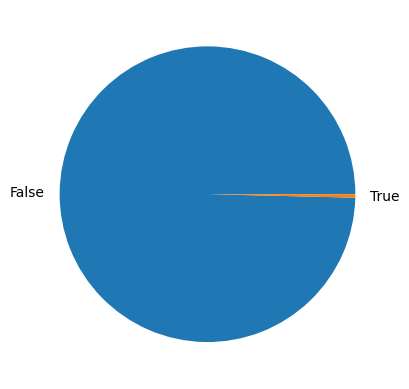

In [4]:
spreadsheet['cyclist-fatalities'] = spreadsheet['cyclists-killed'] != 0

# Creating a pie chart to visualize cyclists deaths versus injuries
fatality_counts = spreadsheet['cyclist-fatalities'].value_counts()
display(fatality_counts)

plt.pie(fatality_counts, labels=fatality_counts.index, shadow = False)


## Q2 - Where are accidents happening?

These data rows contain latitude and longitude information about where the accident occurred. Wouldn't it be cool to plot those out in a way that gives us some kind of reference map to show where danger areas lie? Let's try it!

In [9]:
# throw out rows with invalid coordinates
spreadsheet = spreadsheet[spreadsheet['latitude'] != 0.0]
spreadsheet = spreadsheet[spreadsheet['longitude'] != 0.0]

# get the min and max latitude and longitude data points so we can find a suitable shape file
display(spreadsheet['latitude'].min())
display(spreadsheet['latitude'].max())
display(spreadsheet['longitude'].min())
display(spreadsheet['longitude'].max())

40.506756

40.9109

-74.24828

-73.70061

In [ ]:
# get
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

Archive:  street_map.zip
  inflating: geo_export_d2b45f2c-bc03-4aeb-9e9e-9d452a5d9556.dbf  
  inflating: geo_export_d2b45f2c-bc03-4aeb-9e9e-9d452a5d9556.shp  
  inflating: geo_export_d2b45f2c-bc03-4aeb-9e9e-9d452a5d9556.shx  


<Axes: >

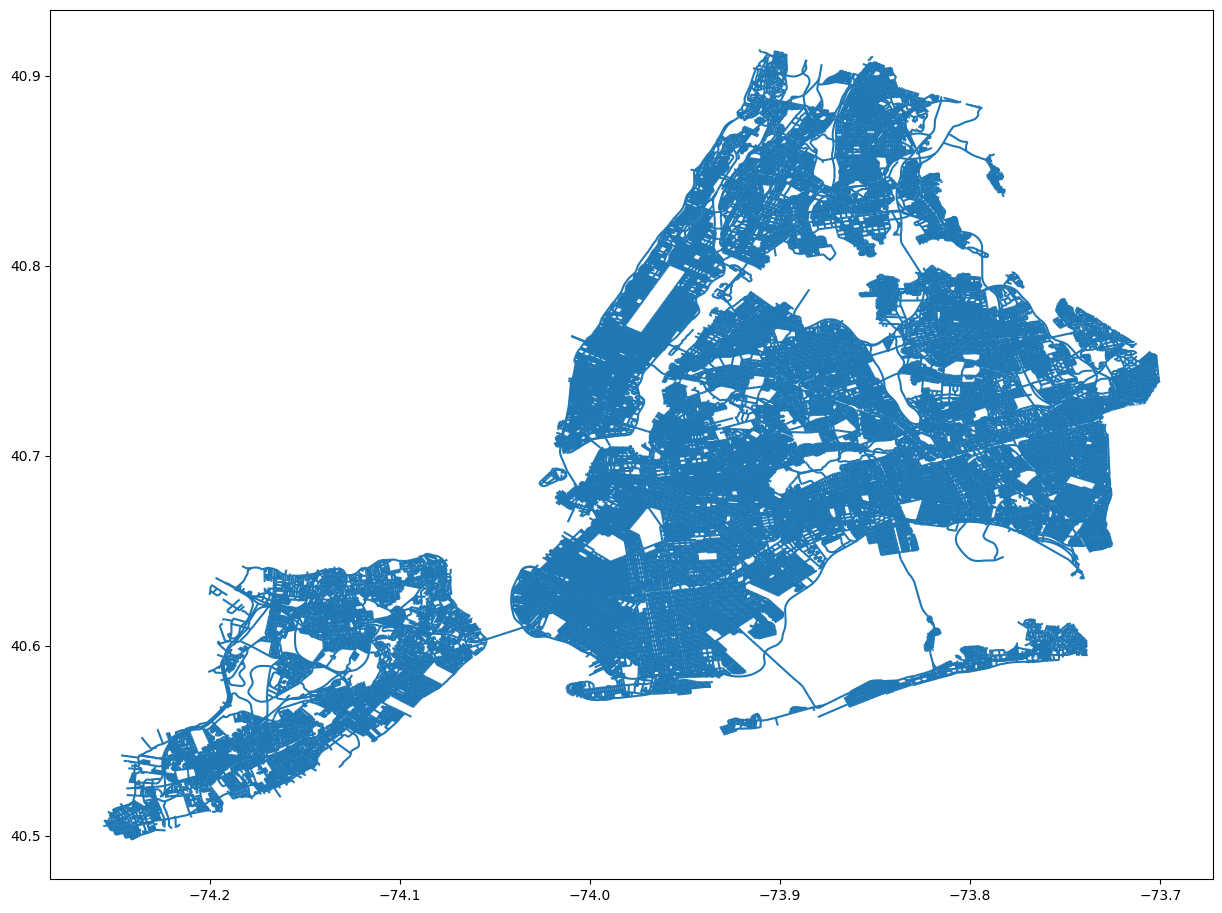

In [28]:
# cool, now let's grab a shape file, plot that and then superimpose our accidents on top of that as points

street_map_id = '14w9K-pqMjRQed9J5pqXfLFEZ_ISzAbXj'
street_map_zip = drive.CreateFile({'id': street_map_id})
street_map_zip.GetContentFile('street_map.zip')
!unzip street_map.zip
street_map = gpd.read_file('geo_export_d2b45f2c-bc03-4aeb-9e9e-9d452a5d9556.shp')

fig, ax = plt.subplots(figsize=(15,15))
street_map.plot(ax=ax)